<a href="https://colab.research.google.com/github/FatmaelzahraaElkhayat/Seisbench_Greece/blob/main/examples/03d_catalog_seisbench_pyocto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/main/examples/03d_catalog_seisbench_pyocto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench and the other required dependencies. If all dependencies are already installed on your machine, you can skip this.*

In [2]:
!pip install seisbench pyocto

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [3]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Creating a catalog - From waveforms to events

This model shows how to use [SeisBench](https://github.com/seisbench/seisbench) and the [PyOcto associator](https://github.com/yetinam/pyocto) to create an earthquake catalog from raw waveforms. First, we will download raw waveforms and station metadata through FDSN. Second, we use an PhaseNet model in SeisBench to obtain phase arrival picks. Third, we use the PyOcto associator to associate the picks to events. We visualize the results.

In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import pyocto
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")

## Obtaining the data

We download waveform data for 12 hours from the CX network in Northern Chile. We use the 5rd April 2014, about 72 hours after the Mw 8.1 Iquique mainshock late on 1st April 2014. Therefore, we expect to see high levels of aftershock activity. In addition to the waveform data, we download the station inventories. Downloading the data might take a few minutes.

In [4]:
client = Client("GFZ")

t0 = UTCDateTime("2014/04/05 00:00:00")
t1 = t0 + 12 * 60 * 60
# t1 = t0 + 24 * 60 * 60   # Full day, requires more memory

stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)
inv = client.get_stations(network="CX", station="*", location="*", channel="HH?", starttime=t0, endtime=t1)

## Picking

For this example, we use PhaseNet trained on the INSTANCE dataset from Italy. However, in principal any picker could be used for obtaining the picks with only minimal changes.

**Warning:** This will take some time and requires sufficient main memory. If you are short on memory, reduce the study time in the cell before.

**Note:** We automatically check if CUDA is available and run the model on CUDA in this case. Alternatively, the model runs on CPU.

In [5]:
picker = sbm.PhaseNet.from_pretrained("instance")

if torch.cuda.is_available():
    picker.cuda()

# We tuned the thresholds a bit - Feel free to play around with these values
picks = picker.classify(stream, batch_size=256, P_threshold=0.05, S_threshold=0.05).picks

Downloading: 100%|██████████| 1.06M/1.06M [00:00<00:00, 1.30MB/s]


Let's have a look at the picks determined by the model.

In [6]:
counts = Counter([p.phase for p in picks])
print("P picks:", counts["P"], "\t\tS picks:", counts["S"], "\n")  # Output number of P and S picks
print(picks)

P picks: 9311 		S picks: 5938 

PickList with 15249 entries:

CX.MNMCX.	2014-04-05T00:00:56.600000Z	P
CX.MNMCX.	2014-04-05T00:01:48.900000Z	P
CX.MNMCX.	2014-04-05T00:02:05.900000Z	P
...
CX.PSGCX.	2014-04-05T11:58:36.609999Z	P
CX.PSGCX.	2014-04-05T11:58:43.819999Z	P
CX.PSGCX.	2014-04-05T11:58:58.209999Z	S


## Configuring the associator

We now set up the associator. First, we define a velocity model to use. We go for a homogeneous velocity model. While a crude approximation in a subduction zone, it still gives good association. Check out the [PyOcto documentation](https://pyocto.readthedocs.io/en/latest/pages/velocity_models.html) for details on velocity models and how to use 1D models.

In [7]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
    association_cutoff_distance=250,
)

Next, we create the associator. We use the `from_area` function, as it will automatically select a local coordinate projection to use for the association. In addition, we set the overlap time (`time_before`), and pick based quality control criteria.

In [8]:
associator = pyocto.OctoAssociator.from_area(
    lat=(-25, -18),
    lon=(-71.5, -68),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)

Lastly, we convert the station information from the obspy inventory to the data frame required for PyOcto.

In [9]:
stations = associator.inventory_to_df(inv)

## Association

We now run the phase association. We use the `associate_seisbench` function that directly takes the output of a SeisBench picking model as input. PyOcto offers further interfaces, for example, to input Pandas data frames. The association will take a moment (up to a few minutes on slower CPUs). The output are two dataframe:

- `events` contains a list of all events with their location and origin times
- `assignments` contains all picks and the event they are associated with

In [10]:
events, assignments = associator.associate_seisbench(picks, stations)

The events currently only contain locations in a local coordinate system. Let's transform it back to latitude and longitude before inspecting the events.

In [11]:
associator.transform_events(events);

## Visualizing the catalog

Let's have a look at the list of events. Every event is listed with its time, local coordinates (x, y, z), the number of picks and the latitude, longitude and depth. Within the 12 hours of the example, we found over 400 event, on average one event every 100 seconds.

In [12]:
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,1.396656e+09,-128.157123,170.282269,30.859375,17,-19.957735,-70.974262,30.859375
1,1,1.396656e+09,-102.091267,200.603081,1.953125,14,-19.685422,-70.723621,1.953125
2,2,1.396656e+09,-19.549392,199.087040,77.734375,10,-19.701660,-69.936464,77.734375
3,3,1.396656e+09,-104.987474,95.996280,0.390625,10,-20.630028,-70.757282,0.390625
4,4,1.396656e+09,-119.468504,73.255672,24.609375,13,-20.834521,-70.897745,24.609375
...,...,...,...,...,...,...,...,...,...
444,444,1.396699e+09,-81.817824,168.008208,0.390625,12,-19.980776,-70.531732,0.390625
445,445,1.396699e+09,-26.789907,174.830391,51.171875,17,-19.920689,-70.005874,51.171875
446,446,1.396699e+09,-35.478526,161.944046,47.265625,24,-20.036952,-70.089108,47.265625
447,447,1.396699e+09,-131.053329,131.623234,25.390625,16,-20.306663,-71.004707,25.390625


We can also plot the catalog. Conveniently, we already have a local transverse mercator projection available, so no need for further thought in the plotting here. We use the `scatter` function and encode the depth of the events using color. The plot nicely resolves the intense shallow aftershock activity. It also shows the seismicity along the Slap (West-East dipping).

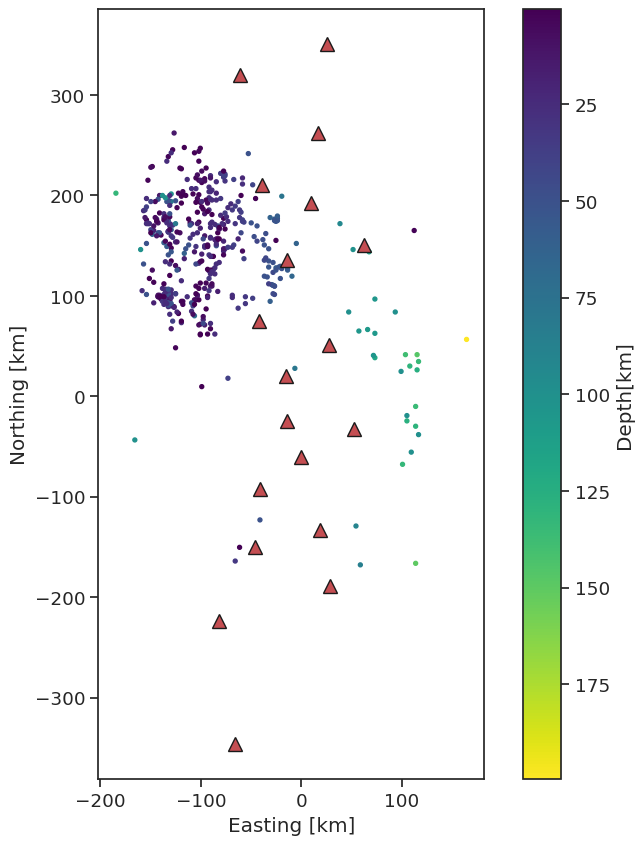

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(events["x"], events["y"], c=events["z"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(stations["x"], stations["y"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()

As a last check, we manually inspect some events. The code block below selects a random event and plots the waveforms, together with the P (solid black lines) and S (dashed black lines). The x axis denotes the time, the y axis the distance between station and estimated event location. Therefore, we should see roughly a hyperbolic moveout. Run the cell a few times to see a few example events.

Event information
idx          1.430000e+02
time         1.396670e+09
x           -1.310533e+02
y            9.523826e+01
z            2.539062e+01
picks        1.100000e+01
latitude    -2.063523e+01
longitude   -7.100738e+01
depth        2.539062e+01
Name: 143, dtype: float64


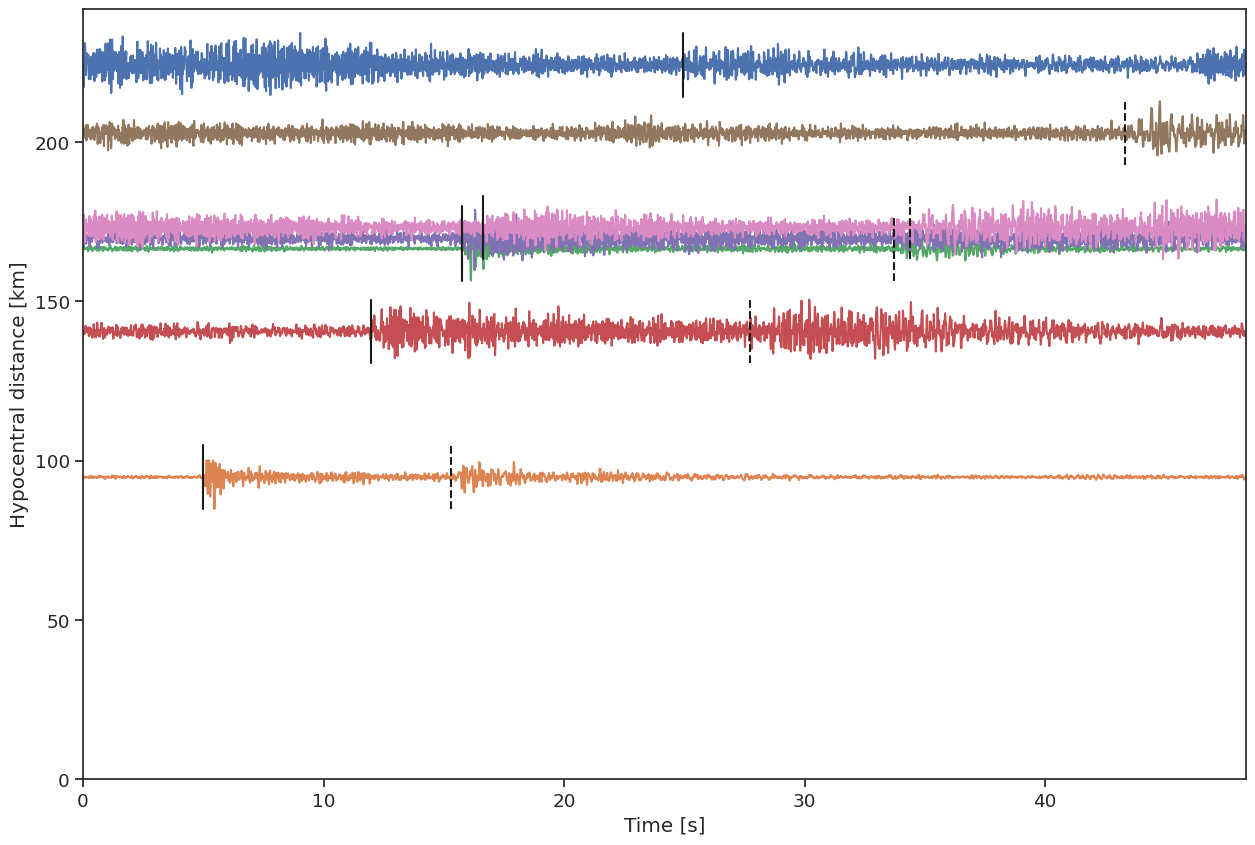

In [14]:
event_idx = np.random.choice(events["idx"])
event_picks = [picks[i] for i in assignments[assignments["event_idx"] == event_idx]["pick_idx"]]
event = events[events["idx"] == event_idx].iloc[0]

station_dict = {station: (x, y) for station, x, y in zip(stations["id"], stations["x"], stations["y"])}

first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

sub = obspy.Stream()

for station in np.unique([pick.trace_id for pick in event_picks]):
    sub.append(stream.select(station=station[3:-1], channel="HHZ")[0])

sub = sub.slice(first - 5, last + 5)

sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))
    station_x, station_y = station_dict[trace.id[:-4]]
    y = np.sqrt((station_x - event["x"]) ** 2 + (station_y - event["y"]) ** 2 + event["z"] ** 2)
    ax.plot(trace.times(), 10 * normed + y)

for pick in event_picks:
    station_x, station_y = station_dict[pick.trace_id]
    y = np.sqrt((station_x - event["x"]) ** 2 + (station_y - event["y"]) ** 2 + event["z"] ** 2)
    x = pick.peak_time - trace.stats.starttime
    if pick.phase == "P":
        ls = '-'
    else:
        ls = '--'
    ax.plot([x, x], [y - 10, y + 10], 'k', ls=ls)

ax.set_ylim(0)
ax.set_xlim(0, np.max(trace.times()))
ax.set_ylabel("Hypocentral distance [km]")
ax.set_xlabel("Time [s]")

print("Event information")
print(event)

## Closing remarks

In this tutorial, we saw how to quickly generate an event catalog from raw seismic waveforms and their metadata using SeisBench and the PyOcto associator.

- Both the picker and the associator have several tuning parameters. We tuned these parameters loosely, but we would like to make the reader aware that these parameters can have strong influence on the number of picks and events, the number of false positives, and the runtime performance of the associator. To learn more about PyOcto, check out the [Github repository](https://github.com/yetinam/pyocto) and the [documentation](https://pyocto.readthedocs.io/en/latest/index.html).
- While PyOcto outputs locations, these are only preliminary. They will usually not be as accurate as locations determined with dedicated tools, such as NonLinLoc. It is highly recommended to follow-up the event detection with a dedicated location procedure.